# Explainable AI for Multi-Class Neurological Disorder Identification from **MRI**

## Setting up Kaggle Directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d omarradi1993/mri-scans-brain-neurological-classes

Dataset URL: https://www.kaggle.com/datasets/omarradi1993/mri-scans-brain-neurological-classes
License(s): CC0-1.0
 94% 470M/503M [00:03<00:00, 146MB/s]
100% 503M/503M [00:05<00:00, 104MB/s]


In [ ]:
!unzip -q /content/mri-scans-brain-neurological-classes.zip -d /content/mri_dataset


In [ ]:
!cp -r /content/drive/MyDrive/TS_DataSet /content/

In [ ]:
!unzip -q AD.zip

## Installing Packages

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import DenseNet121, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

/tmp/ipython-input-1887852596.py:7: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


## Data Cleaning

In [ ]:
data_path = "/content/AD/train"
file_types = ['jpeg','jpg','png']

removed = 0
for root,dirs,files in os.walk(data_path):
    for file in files:
      file_path = os.path.join(root,file)

      try:
        file_type = imghdr.what(file_path)
        if file_type not in file_types:
          print(f'file not exist in list {file_path}')
          os.remove(file_path)
          removed += 1
      except Exception as e:
        print(f'Issue with file {file_path}')
        os.remove(file_path)
        removed += 1
print(f'\nTotal files removed from {data_path}: {removed}')


Total files removed from /content/AD/train: 0


In [ ]:
root_folder = '/content/AD/train'

results = []

for class_name in os.listdir(root_folder):
    class_path = os.path.join(root_folder, class_name)
    if os.path.isdir(class_path):
        rgb_count = 0
        rgba_count = 0
        grayscale_count = 0

        for filename in os.listdir(class_path):
          img_path = os.path.join(class_path, filename)
          img = Image.open(img_path)
          mode = img.mode
          if mode == 'RGB':
              rgb_count += 1
          elif mode == 'RGBA':
              rgba_count += 1
          elif mode == 'L':
              grayscale_count += 1

        results.append({
            'Class': class_name,
            'RGB': rgb_count,
            'RGBA': rgba_count,
            'Grayscale': grayscale_count
        })

df = pd.DataFrame(results)
print(df)


        Class    RGB  RGBA  Grayscale
0  Alzahaimer  10242     0        948
1      Normal   9560     0       2672


## Data Analysis

In [ ]:
def count_files_in_dir(dir):
  count = {}

  for item in os.listdir(dir):
    item_path = os.path.join(dir,item)
    if os.path.isdir(item_path):
      count[item] = len(os.listdir(item_path))

  df = pd.DataFrame(list(count.items()), columns=["Class", "Count"])
  return df


data_path = "/content/AD/train"
count = count_files_in_dir(data_path)
print('\nImages in each class :\n',count)


Images in each class :
         Class  Count
0  Alzahaimer  11190
1      Normal  12232


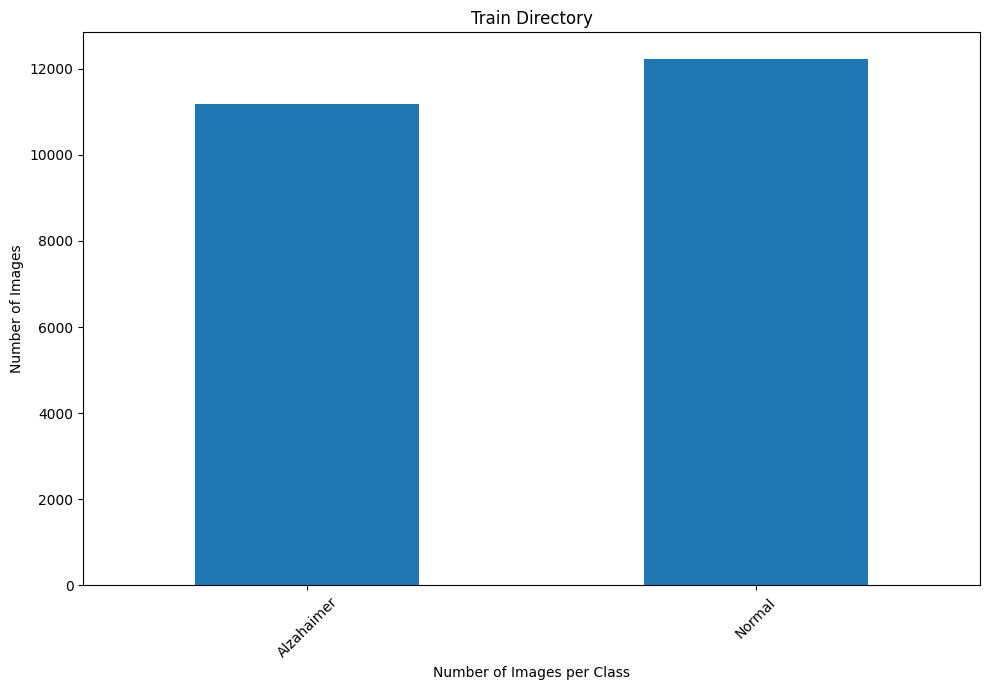

In [ ]:
fig,axes = plt.subplots(figsize=(10,7))


count.plot(x='Class',y='Count',kind='bar',legend=False,ax=axes)
axes.set_ylabel('Number of Images')
axes.set_xlabel('Number of Images per Class')
axes.set_title('Train Directory')
axes.set_xticklabels(axes.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

## Plotting one image from each disorder.

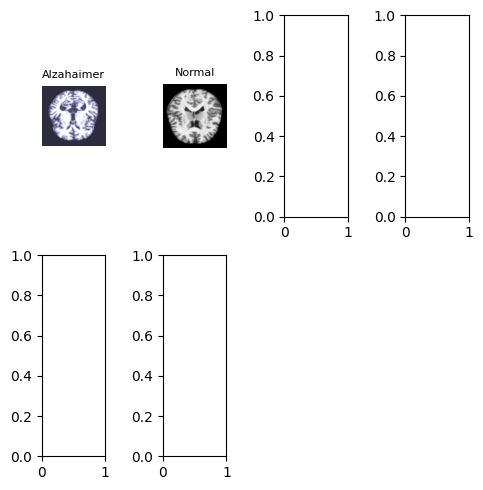

In [ ]:
import textwrap

data_path = "/content/AD/train"
disorders = os.listdir(data_path)

fig,axes = plt.subplots(2,4,figsize=(5,5))
axes = axes.flatten()

for i,disorder in enumerate(disorders):
  folder = os.path.join(data_path,disorder)
  img_path = os.path.join(folder,os.listdir(folder)[42])
  img = Image.open(img_path)
  axes[i].imshow(img,cmap='gray')
  axes[i].set_title("\n".join(textwrap.wrap(disorder, 10)), fontsize=8)  # wrap every 10 chars
  axes[i].axis('off')

for j in range(len(disorder), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## Loading Shapes and Channels

In [ ]:
def image_to_array(image_path):
    try:
        with Image.open(image_path) as img:
            image_array = np.array(img)
            return image_array
    except IOError:
        print(f"Could not read the image file at {image_path}.")
        return None

In [ ]:
image_to_array('/content/TS_DataSet/Alzheimer''s Disease/1.jpg')

Could not read the image file at /content/TS_DataSet/Alzheimers Disease/1.jpg.


In [ ]:
img_array = image_to_array('/content/mri_dataset/AD_MildDemented/26 (19).jpg')

if (img_array[:,:,0] == img_array[:,:,1]).all() and (img_array[:,:,1] == img_array[:,:,2]).all():
    print("All 3 channels are identical → image is grayscale stored as RGB.")
else:
    print("Channels differ → image is true RGB.")


All 3 channels are identical → image is grayscale stored as RGB.


# **Model 2 : Transfer Leanring - ResNet50**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input

# Directory paths for training and testing data
train_dir = '/content/AD/train'

# Batch size for data generators
batch_size = 16


train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=5,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest',
    validation_split=0.2
)


# Data generators for training and testing data
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,  # Directory containing training data
                                                    class_mode="binary",  # binary mode for binary labels
                                                    target_size=(224, 224),  # Resize input images to (224,224)
                                                    color_mode='rgb',  # Color mode for images (RGB)
                                                    shuffle=True,  # Shuffle training data
                                                    batch_size=batch_size,  # Batch size for training
                                                    subset='training'  # Subset of data (training)

                                                    )
# VALIDATION DATA (NO augmentation)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,
    subset='validation'
)




Found 18738 images belonging to 2 classes.
Found 4684 images belonging to 2 classes.


In [ ]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

# classes - 7(normal),0,2

Class Weights Dictionary: {0: np.float64(1.0465817694369972), 1: np.float64(0.957388105456775)}


In [ ]:
model = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
len(model.layers)

190

In [ ]:
model.trainable = False

In [ ]:
model.trainable = True

for layer in model.layers[:-66]:
    layer.trainable = False

In [ ]:
# model = Sequential([
#     model,
#     GlobalAveragePooling2D(),
#     Dropout(0.25),
#     BatchNormalization(),
#     Dense(64, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(8,activation='softmax')
#     ])

# model = tf.keras.Sequential([
#     model,
#     GlobalAveragePooling2D(),
#     BatchNormalization(),
#     Dense(128, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(3, activation='softmax')
# ])

# model.summary()

from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    Dropout,
    BatchNormalization
)
from tensorflow.keras.models import Model

x = model.output                 # 4D tensor
x = GlobalAveragePooling2D()(x)       # → 2D
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=model.input, outputs=outputs)

In [ ]:
#Phase 1
# model.compile(
#     optimizer=Adam(learning_rate=1e-4),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/ResNet50_Transfer_Learning'
name = 'ResNet50_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')



# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, csv_logger]

In [ ]:
# train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# test_steps_epoch = val_generator.samples // val_generator.batch_size + 1

import math

train_steps_per_epoch = math.ceil(train_generator.samples / train_generator.batch_size)
test_steps_epoch = math.ceil(val_generator.samples / val_generator.batch_size)

print(train_steps_per_epoch)
print(test_steps_epoch)

1172
293


In [ ]:
import os

cnn_path = "/content/ResNet50_Transfer_Learning"
os.makedirs(cnn_path, exist_ok=True)


In [ ]:
train_history = model.fit(
                          train_generator,
                          steps_per_epoch=train_steps_per_epoch,
                          epochs=10,
                          validation_data=val_generator,
                          validation_steps=test_steps_epoch,
                          class_weight=class_weights_dict,
                          callbacks = callbacks
                         )

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7280 - auc: 0.7967 - loss: 0.6035 - recall: 0.7130
Epoch 1: val_loss improved from inf to 0.24971, saving model to /content/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 270s 218ms/step - accuracy: 0.7281 - auc: 0.7967 - loss: 0.6034 - recall: 0.7131 - val_accuracy: 0.9009 - val_auc: 0.9660 - val_loss: 0.2497 - val_recall: 0.8679
Epoch 2/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8188 - auc: 0.9016 - loss: 0.4149 - recall: 0.8029
Epoch 2: val_loss improved from 0.24971 to 0.22317, saving model to /content/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 242s 207ms/step - accuracy: 0.8188 - auc: 0.9016 - loss: 0.4149 - recall: 0.8029 - val_accuracy: 0.9103 - val_auc: 0.9755 - val_loss: 0.2232 - val_recall: 0.8724
Epoch 3/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8443 - auc: 0.9234 - loss: 0.356

In [ ]:
def plot_training_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

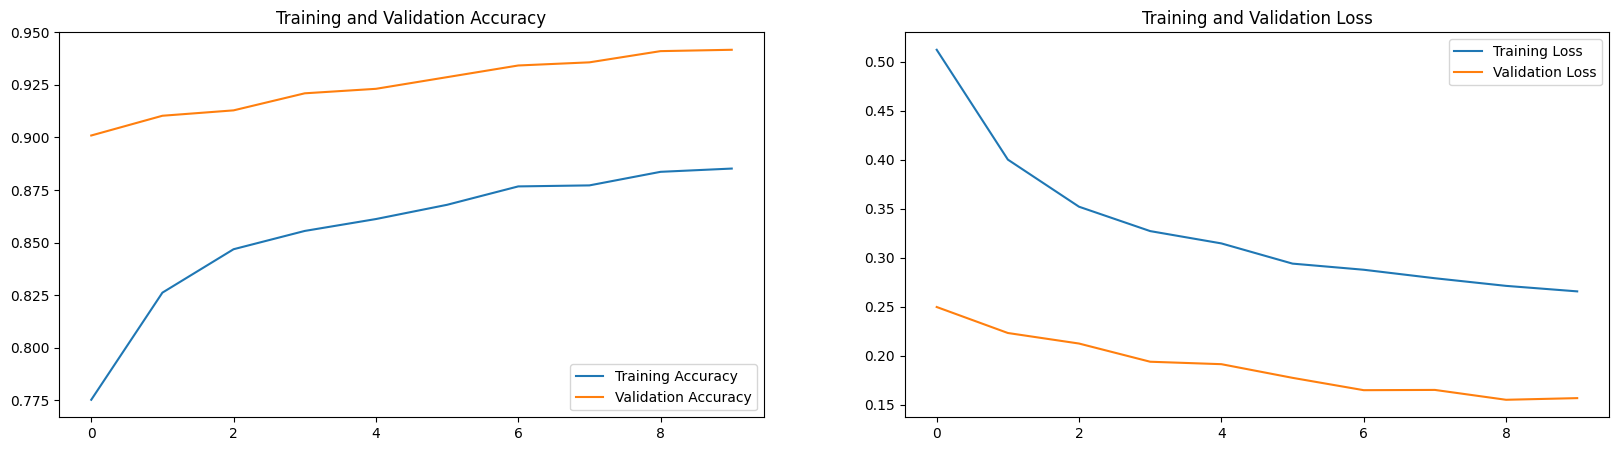

In [ ]:
plot_training_history(train_history)

In [ ]:
import keras
My_Model = keras.saving.load_model('/content/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras')

In [ ]:
train_results = My_Model.evaluate(train_generator, verbose=0)
val_results   = My_Model.evaluate(val_generator, verbose=0)

print(f"Train Accuracy  : {train_results[1]*100:.2f}%")
print(f"Train AUC       : {train_results[2]:.4f}")
print(f"Train Recall    : {train_results[3]:.4f}")

print("------------------------------------------------")

print(f"Val Accuracy    : {val_results[1]*100:.2f}%")
print(f"Val AUC         : {val_results[2]:.4f}")
print(f"Val Recall      : {val_results[3]:.4f}")


Train Accuracy  : 93.21%
Train AUC       : 0.9839
Train Recall    : 0.9281
------------------------------------------------
Val Accuracy    : 94.11%
Val AUC         : 0.9897
Val Recall      : 0.9146


In [ ]:
import numpy as np

y_true = val_generator.classes
y_prob = My_Model.predict(val_generator).ravel()
y_pred = (y_prob >= 0.5).astype(int)


293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step


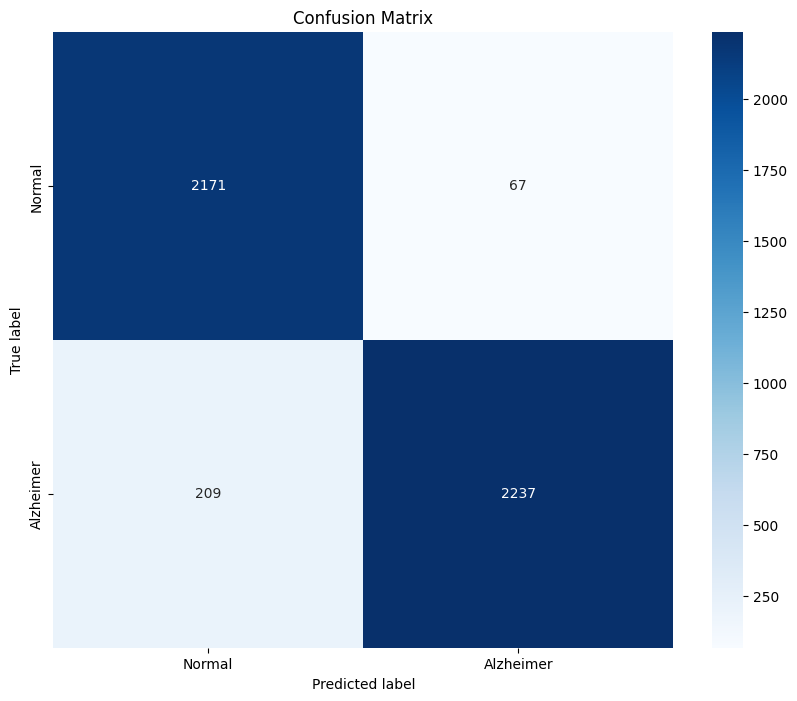

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
class_labels = ['Normal', 'Alzheimer']
cm = confusion_matrix(y_true, y_pred)
# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



In [ ]:
print("\nClassification Report:")
print(classification_report(
    y_true, y_pred,
    target_names=['Normal', 'Alzheimer']
))


Classification Report:
              precision    recall  f1-score   support

      Normal       0.91      0.97      0.94      2238
   Alzheimer       0.97      0.91      0.94      2446

    accuracy                           0.94      4684
   macro avg       0.94      0.94      0.94      4684
weighted avg       0.94      0.94      0.94      4684



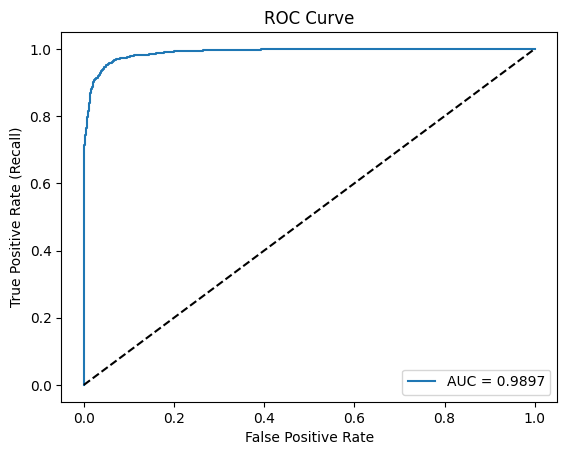

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/Test_model_Phase_1.keras")

In [ ]:
import keras

In [ ]:
import keras
My_Model = keras.saving.load_model('/content/drive/MyDrive/Test_model_Phase_1.keras')

In [ ]:
train_loss, train_accu = My_Model.evaluate(train_generator)
test_loss, test_accu = My_Model.evaluate(val_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

1503/1503 ━━━━━━━━━━━━━━━━━━━━ 316s 207ms/step - accuracy: 0.9999 - loss: 4.7366e-04
376/376 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8852 - loss: 0.8343
final train accuracy = 99.99 , validation accuracy = 83.38


# Phase 2

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

My_Model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/AD_2'
name = 'AD_2.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint

checkpoint = ModelCheckpoint(
    filepath=chk_path,
    monitor='val_recall',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, csv_logger]

In [ ]:
import os

cnn_path = "/content/AD_2"
os.makedirs(cnn_path, exist_ok=True)

In [ ]:
train_history = My_Model.fit(
                          train_generator,
                          steps_per_epoch=train_steps_per_epoch,
                          epochs=10,
                          validation_data=val_generator,
                          validation_steps=test_steps_epoch,
                          class_weight=class_weights_dict,
                          callbacks = callbacks
                         )

Epoch 1/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8912 - auc: 0.9597 - loss: 0.2573 - recall: 0.8886
Epoch 1: val_recall improved from -inf to 0.90679, saving model to /content/AD_2/AD_2.keras
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 262s 214ms/step - accuracy: 0.8912 - auc: 0.9597 - loss: 0.2573 - recall: 0.8886 - val_accuracy: 0.9400 - val_auc: 0.9903 - val_loss: 0.1583 - val_recall: 0.9068
Epoch 2/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.8879 - auc: 0.9576 - loss: 0.2630 - recall: 0.8875
Epoch 2: val_recall improved from 0.90679 to 0.90965, saving model to /content/AD_2/AD_2.keras
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 244s 203ms/step - accuracy: 0.8879 - auc: 0.9576 - loss: 0.2630 - recall: 0.8875 - val_accuracy: 0.9406 - val_auc: 0.9903 - val_loss: 0.1557 - val_recall: 0.9096
Epoch 3/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8933 - auc: 0.9609 - loss: 0.2539 - recall: 0.8932
Epoch 3: val_recall improved from 0.90965 to 0.91455, saving mod

In [ ]:
# Train Accuracy  : 93.21%
# Train AUC       : 0.9839
# Train Recall    : 0.9281
# ------------------------------------------------
# Val Accuracy    : 94.11%
# Val AUC         : 0.9897
# Val Recall      : 0.9146

In [ ]:
import keras
My_Model2 = keras.saving.load_model('/content/AD_2/AD_2.keras')

In [ ]:
train_results = My_Model2.evaluate(train_generator, verbose=1)
val_results   = My_Model2.evaluate(val_generator, verbose=1)

print(f"Train Accuracy  : {train_results[1]*100:.2f}%")
print(f"Train AUC       : {train_results[2]:.4f}")
print(f"Train Recall    : {train_results[3]:.4f}")

print("------------------------------------------------")

print(f"Val Accuracy    : {val_results[1]*100:.2f}%")
print(f"Val AUC         : {val_results[2]:.4f}")
print(f"Val Recall      : {val_results[3]:.4f}")

1172/1172 ━━━━━━━━━━━━━━━━━━━━ 243s 202ms/step - accuracy: 0.9378 - auc: 0.9863 - loss: 0.1649 - recall: 0.9319
293/293 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9683 - auc: 0.5224 - loss: 0.0969 - recall: 0.4831
Train Accuracy  : 93.67%
Train AUC       : 0.9857
Train Recall    : 0.9300
------------------------------------------------
Val Accuracy    : 94.58%
Val AUC         : 0.9914
Val Recall      : 0.9182


In [ ]:
My_Model1 = keras.saving.load_model('/content/ResNet50_Transfer_Learning/AD Vs Normal.keras')

In [ ]:
train_results = My_Model1.evaluate(train_generator, verbose=1)
val_results   = My_Model1.evaluate(val_generator, verbose=1)

print(f"Train Accuracy  : {train_results[1]*100:.2f}%")
print(f"Train AUC       : {train_results[2]:.4f}")
print(f"Train Recall    : {train_results[3]:.4f}")

print("------------------------------------------------")

print(f"Val Accuracy    : {val_results[1]*100:.2f}%")
print(f"Val AUC         : {val_results[2]:.4f}")
print(f"Val Recall      : {val_results[3]:.4f}")

1172/1172 ━━━━━━━━━━━━━━━━━━━━ 237s 197ms/step - accuracy: 0.9295 - auc: 0.9838 - loss: 0.1780 - recall: 0.9257
293/293 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9642 - auc: 0.5214 - loss: 0.1087 - recall: 0.4788
Train Accuracy  : 92.96%
Train AUC       : 0.9832
Train Recall    : 0.9250
------------------------------------------------
Val Accuracy    : 94.11%
Val AUC         : 0.9897
Val Recall      : 0.9146


In [ ]:
import numpy as np

y_true = val_generator.classes
y_prob = My_Model2.predict(val_generator).ravel()
y_pred = (y_prob >= 0.5).astype(int)

293/293 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step


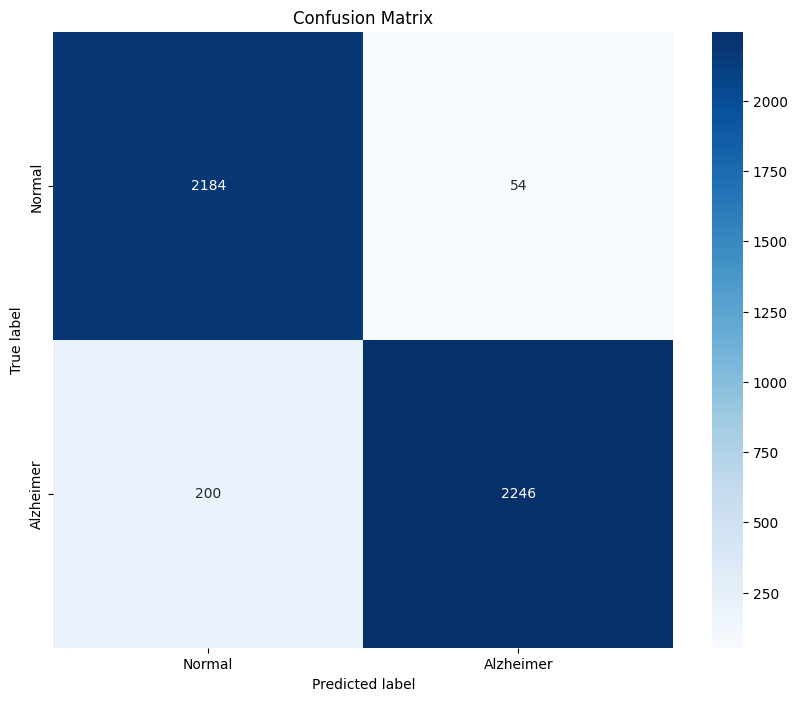

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
class_labels = ['Normal', 'Alzheimer']
cm = confusion_matrix(y_true, y_pred)
# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Get correct class order from training generator
class_names = list(train_generator.class_indices.keys())

def predict_image(path, model):
    # Load image
    img = load_img(path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # IMPORTANT: same preprocessing as training
    img_array = preprocess_input(img_array)

    # Prediction
    prediction = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction) * 100

    # Display
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {class_names[predicted_class]} ({confidence:.2f}%)")
    plt.show()


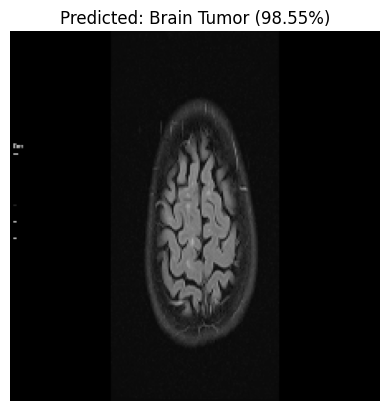

In [ ]:
path = '/content/MS-A (106).png'
predict_image(path,model)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

def predict_image1(path, model):
    disorders = ['AD_VeryMildDemented', 'Normal', 'AD_MildDemented',
                 'BT_pituitary', 'AD_ModerateDemented', 'BT_meningioma',
                 'BT_glioma', 'MS']

    # Automatically extract actual label from folder name
    actual_label = os.path.basename(os.path.dirname(path))

    # Load and preprocess image
    img = load_img(path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize

    # Model prediction
    prediction = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Color-coded title (green if correct, red if wrong)
    color = "green" if actual_label == disorders[predicted_class] else "red"

    # Display image
    plt.imshow(img)
    plt.axis('off')
    plt.title(
        f"Actual: {actual_label}\nPredicted: {disorders[predicted_class]}",
        fontsize=12, color=color, loc='center'
    )
    plt.show()


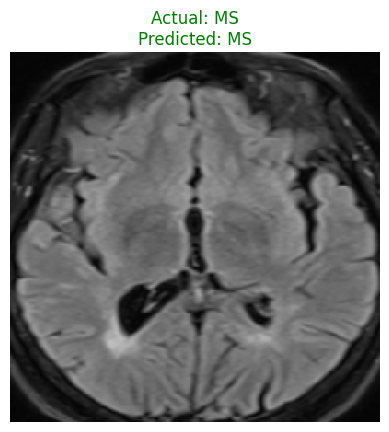

In [ ]:
path = '/content/mri_dataset/MS/MS-A (138).png'
predict_image1(path, My_Model)


In [ ]:
import keras
My_Model = keras.saving.load_model('/content/drive/MyDrive/TS_model/Test_model.keras')

In [ ]:
train_loss, train_accu = My_Model.evaluate(train_generator)
test_loss, test_accu = My_Model.evaluate(val_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


206/206 ━━━━━━━━━━━━━━━━━━━━ 196s 890ms/step - accuracy: 0.8364 - loss: 0.3790
52/52 ━━━━━━━━━━━━━━━━━━━━ 45s 867ms/step - accuracy: 0.5958 - loss: 0.9181
final train accuracy = 83.51 , validation accuracy = 73.49
